# k-NN k-Nearest Neighbours (k-Plus Proches Voisins)
<hr>
# Inspiré par : cours-IFT6390 - Automne 2021, sessions de laboratoir (matérial et code du cours sur les k-NN), démo 9 "librairie Scikit-learn"

In [73]:
import sklearn

In [74]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [75]:
import sys
import argparse
import pandas as pd

import gensim

In [76]:
from sklearn.neighbors import KNeighborsClassifier

In [77]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Outils

In [78]:
def make_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument('--train_file', type=str)
    parser.add_argument('--dev_file', type=str)
    parser.add_argument('--dataset_name', type=str)
    parser.add_argument('--representation', type=str)
    return parser

In [79]:
def read_data(file_name: str, dataset_name: str) -> pd.DataFrame:
    """
    Lecture des fichiers de données
    :param file_name: str, nom du fichier à lire
    :param dataset_name: str, nom du dataset auquel appartient le fichier
    :return: un dataframe pandas contenant une colonne "sentence" qui sont les exemples et une colonne "label" qui sont
    les labels associés aux exemples
    """
    # lecture fichier sous forme tsv
    if dataset_name == "cola":
        data = pd.read_csv(file_name, sep="\t", header=None)
    else:
        data = pd.read_csv(file_name, sep='\t')

    # standardization des données, i.e. création des colonnes 'sentence' et 'label' contenant les phrases exemples et
    # les classes associées
    if dataset_name == 'cola':
        data.columns = ["id", "label", "label2", "sentence"]
    elif dataset_name == 'qqp':
        data['sentence'] = data.apply(
            lambda row: row['question1'] + ' ' + row['question2'], axis=1)
        data = data.rename(columns={'is_duplicate': 'label'})

    return data

In [80]:
def read_corpus(data):
    for i, line in enumerate(data["sentence"]):
        tokens = gensim.utils.simple_preprocess(line)
        yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

In [81]:
# HYPERPARAMETER à évaluer : vector_size
def convert_to_matrix(corpus, data, vector_size=30):
    model = gensim.models.doc2vec.Doc2Vec(
        vector_size=vector_size, min_count=2, epochs=40)
    model.build_vocab(corpus)
    model.train(corpus, total_examples=model.corpus_count,
                epochs=model.epochs)
    sentence2vec = [model.infer_vector((data["sentence"][i].split(
        " "))) for i in range(0, len(data["sentence"]))]
    stv = np.array(sentence2vec)

    return stv

In [82]:
# HYPERPARAMETER à évaluer : k
def train_model(X_train, y_train, X_dev, y_dev, k_nn = 10):
    k_values = np.arange(1, k_nn, 2)
    k_test = []
    k_train = []
    for k in k_values:
        knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                            metric_params=None, n_jobs=None, n_neighbors=k, p=2,
                            weights='uniform')
        knn.fit(X_train, y_train)

        train_pred = knn.predict(X_train)
        k_train.append((train_pred == y_train).mean())
        test_pred = knn.predict(X_dev)
        k_test.append((test_pred == y_dev).mean())
        acc = classification_report(y_dev, test_pred)
        print(f'Accuracy on dev set for k-nn = {k}')
        print(acc)

    plt.xlabel('k\'s value')
    plt.ylabel('Performance')
    plt.plot(k_values, k_test, label='test set',color='b')
    plt.plot(k_values, k_train, label='train_set',color='r')
    
    return k_train, k_test

In [44]:
# def test_model(model, X_test, y_test):
#     # Évaluation du modèle sur les données de test

#     print("Testing model")
#     y_pred = model.predict(X_test)

#     acc = classification_report(y_test, y_pred)
#     print("Accuracy on dev set", acc)

# Jupyter Notebook Main
<hr>
# Pour l'execution dans l'environnement Jupyter


In [83]:
# Les arguments (paramètres) d'execution...
# PARAMÈTRES D'EXECUTION
# '--train_file', type=str)
# '--dev_file', type=str)
# '--dataset_name', type=str)
## '--representation', type=str)

# Paramètres (locales) pour SST, au lieu d'utiliser' make_parser(sys.argv[1:])  :
strTrainFile = "C:/UdeM-ws/ift6285_taln/project1/data/sst_train.tsv"
strDevFile = "C:/UdeM-ws/ift6285_taln/project1/data/sst_dev.tsv"
strDataSet = "sst"

train_file = strTrainFile
dev_file = strDevFile
dataset_name = strDataSet
# representation = args.representation

In [84]:
# Input data
print("Reading data, preprocessing...")

# lire les fichiers
train_data = read_data(train_file, dataset_name)
y_train = train_data["label"].to_numpy()
train_corpus = list(read_corpus(train_data))



Reading data, preprocessing...


In [85]:
test_data = read_data(dev_file, dataset_name)
y_test = test_data["label"].to_numpy()

test_corpus = list(read_corpus(test_data))

In [86]:
def eval_diff_vector_size (vSize, k_limit = 10):
    print(f'Evaluating with vector_size = {vSize}')
    X_train = convert_to_matrix(train_corpus, train_data, vector_size=vSize)   # avec hyperparameter vector_size = 30
    X_test = convert_to_matrix(test_corpus, test_data, vector_size=vSize)   # avec hyperparameter vector_size = 30

    # Model training and prediction
    knn_train, knn_test = train_model(X_train, y_train, X_test, y_test)
    print(f'knn_parameter : {np.arange(1, k_limit, 2)}')
    print(f'knn_train performance : {knn_train}, best : {1 + 2*np.argmax(np.array(knn_train))}')
    print(f'knn_test performance : {knn_test}, best : {1 + 2*np.argmax(np.array(knn_test))}')

Evaluating with vector_size = 1
Accuracy on dev set for k-nn = 1
              precision    recall  f1-score   support

           0       0.52      0.48      0.50       428
           1       0.53      0.57      0.55       444

    accuracy                           0.53       872
   macro avg       0.53      0.53      0.53       872
weighted avg       0.53      0.53      0.53       872

Accuracy on dev set for k-nn = 3
              precision    recall  f1-score   support

           0       0.51      0.47      0.49       428
           1       0.52      0.56      0.54       444

    accuracy                           0.52       872
   macro avg       0.52      0.52      0.51       872
weighted avg       0.52      0.52      0.51       872

Accuracy on dev set for k-nn = 5
              precision    recall  f1-score   support

           0       0.51      0.41      0.46       428
           1       0.52      0.61      0.56       444

    accuracy                           0.51       8

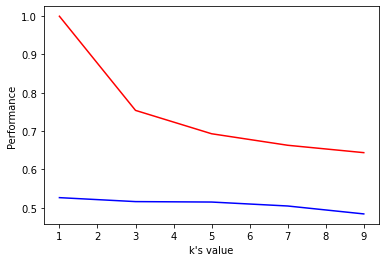

In [87]:
# Évaluation avec hyperparameters :
# .. vector_size = 1, 3, 5, 10, ... 15, 30
# .. k-nn_limit : np.arange(1, k-nn_limit, 2)
eval_diff_vector_size(1, 10)

Evaluating with vector_size = 3
Accuracy on dev set for k-nn = 1
              precision    recall  f1-score   support

           0       0.50      0.45      0.47       428
           1       0.52      0.57      0.54       444

    accuracy                           0.51       872
   macro avg       0.51      0.51      0.51       872
weighted avg       0.51      0.51      0.51       872

Accuracy on dev set for k-nn = 3
              precision    recall  f1-score   support

           0       0.51      0.43      0.46       428
           1       0.52      0.59      0.55       444

    accuracy                           0.51       872
   macro avg       0.51      0.51      0.51       872
weighted avg       0.51      0.51      0.51       872

Accuracy on dev set for k-nn = 5
              precision    recall  f1-score   support

           0       0.50      0.42      0.45       428
           1       0.51      0.59      0.55       444

    accuracy                           0.51       8

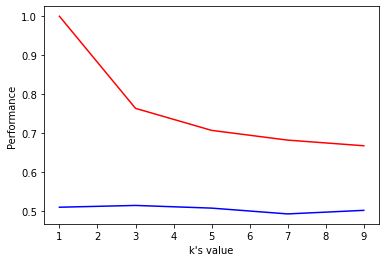

In [88]:
eval_diff_vector_size(3, 10)

Evaluating with vector_size = 5
Accuracy on dev set for k-nn = 1
              precision    recall  f1-score   support

           0       0.46      0.39      0.42       428
           1       0.49      0.56      0.52       444

    accuracy                           0.48       872
   macro avg       0.47      0.48      0.47       872
weighted avg       0.48      0.48      0.47       872

Accuracy on dev set for k-nn = 3
              precision    recall  f1-score   support

           0       0.48      0.39      0.43       428
           1       0.50      0.60      0.55       444

    accuracy                           0.50       872
   macro avg       0.49      0.49      0.49       872
weighted avg       0.49      0.50      0.49       872

Accuracy on dev set for k-nn = 5
              precision    recall  f1-score   support

           0       0.51      0.38      0.44       428
           1       0.52      0.65      0.58       444

    accuracy                           0.52       8

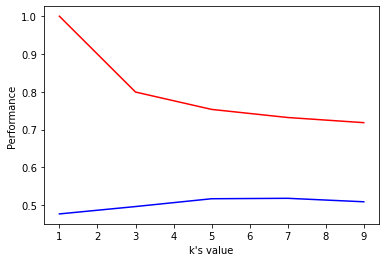

In [89]:
eval_diff_vector_size(5, 10)

Evaluating with vector_size = 10
Accuracy on dev set for k-nn = 1
              precision    recall  f1-score   support

           0       0.46      0.44      0.45       428
           1       0.48      0.50      0.49       444

    accuracy                           0.47       872
   macro avg       0.47      0.47      0.47       872
weighted avg       0.47      0.47      0.47       872

Accuracy on dev set for k-nn = 3
              precision    recall  f1-score   support

           0       0.48      0.46      0.47       428
           1       0.50      0.51      0.50       444

    accuracy                           0.49       872
   macro avg       0.49      0.49      0.49       872
weighted avg       0.49      0.49      0.49       872

Accuracy on dev set for k-nn = 5
              precision    recall  f1-score   support

           0       0.47      0.46      0.47       428
           1       0.49      0.50      0.50       444

    accuracy                           0.48       

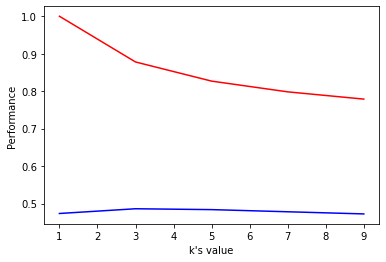

In [90]:
eval_diff_vector_size(10, 10)

Evaluating with vector_size = 15
Accuracy on dev set for k-nn = 1
              precision    recall  f1-score   support

           0       0.55      0.50      0.52       428
           1       0.55      0.60      0.58       444

    accuracy                           0.55       872
   macro avg       0.55      0.55      0.55       872
weighted avg       0.55      0.55      0.55       872

Accuracy on dev set for k-nn = 3
              precision    recall  f1-score   support

           0       0.55      0.49      0.52       428
           1       0.56      0.61      0.58       444

    accuracy                           0.56       872
   macro avg       0.55      0.55      0.55       872
weighted avg       0.55      0.56      0.55       872

Accuracy on dev set for k-nn = 5
              precision    recall  f1-score   support

           0       0.54      0.51      0.52       428
           1       0.55      0.58      0.57       444

    accuracy                           0.55       

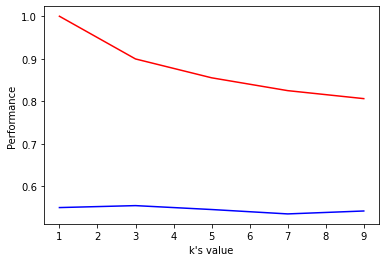

In [91]:
eval_diff_vector_size(15, 10)

Evaluating with vector_size = 20
Accuracy on dev set for k-nn = 1
              precision    recall  f1-score   support

           0       0.46      0.45      0.45       428
           1       0.48      0.49      0.48       444

    accuracy                           0.47       872
   macro avg       0.47      0.47      0.47       872
weighted avg       0.47      0.47      0.47       872

Accuracy on dev set for k-nn = 3
              precision    recall  f1-score   support

           0       0.47      0.45      0.46       428
           1       0.49      0.52      0.51       444

    accuracy                           0.49       872
   macro avg       0.48      0.48      0.48       872
weighted avg       0.48      0.49      0.48       872

Accuracy on dev set for k-nn = 5
              precision    recall  f1-score   support

           0       0.46      0.41      0.43       428
           1       0.49      0.55      0.51       444

    accuracy                           0.48       

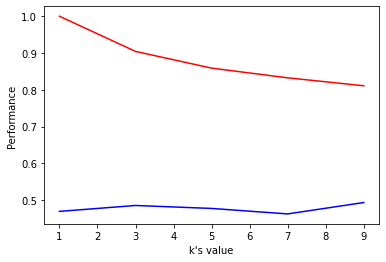

In [92]:
eval_diff_vector_size(20, 10)

# Main
<hr>